 The Indiana Training Program in Public and Population Health Informatics
## Exercise 3 - Tying it all together in the PHESS data
*Competencies addressed*  
 
 1. Identify as well as access structured electronic data sets (I.1.1)
 2. Transformation of raw data to formats more suitable for downstream use cases (I.1.2)
 3. Develop an understanding of processing different kinds of data (e.g. string processing)  (I.1.5)
 4. Demonstrate the ability to describe data (find means, standard deviations, outliers, evaluate correlations etc.) (II.1.2)
 5. Acquire skills related to visualize data to discover patterns (including interactive visualization techniques) (II.1.3)

 *Learning objectives*  
 At the end of this module the student will be able to do the following:

 1. Load a delimited dataset using <font color = "red">fread()</font> from R package **data.table** 
 2. Assess the value of visualizations from an aesthetic and scientific perspective - diagnosis types within FLAG values
 3. Investigate overlap or correlation between distinct flags / indicators in a dataset
 4. Apply commonly used dimension reduction techniques to reduce the number of indicators in the dataset, and investigate the usefulness of this exercise
 
This exercise uses the patient data from the Public Health Emergency Surveillance System (<font color = "blue">PHESS</font>) dataset. The data contains patient level admission information, patient demographics, geographical information such as ZIP code and local population, and several FLAG variables describing the patient's experience upon admission. In this exercise, we'll continue with visualiation, but also utilize a dimension reduction technique (principal components analysis - PCA) to attempt to reduce the size of the feature space of the FLAFG variables in the <font color = "blue">PHESS</font> data.

In [3]:
library(dplyr)
library(ggplot2)
library(tidyr)
library(stringr)
library(data.table)
library(corrplot)
library(purrr)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'data.table'

The following objects are masked from 'package:dplyr':

    between, first, last

corrplot 0.85 loaded

Attaching package: 'purrr'

The following object is masked from 'package:data.table':

    transpose



## Modifying install paths when necessary
When using hosted solutions, the analyst may not be given "administrative privileges" to install additional R packages. However, the analyst can modify the library path that R uses to both install and load packages into the Jupyter notebook session. In this short example, we demonstrate installing a new software package, **ggcorrplot**, which provides nice visual representations of the correlation between FLAG variables in the <font color = 'blue'>PHESS</font> data.

Using package **ggcorrplot** - install to writeable directory created by the analyst using argument **lib**

In [3]:
install.packages("ggcorrplot", lib = "/N/u/slourens/Carbonate/Desktop/PHI/Sample/Notebooks/PHESS Data Set/mylibR/")

load the **ggcorrplot** package from the directory (in this example, **mylibR**, created by analyst using argument **lib.loc**

In [4]:
library(ggcorrplot, lib.loc = "/N/u/slourens/Carbonate/Desktop/PHI/Sample/Notebooks/PHESS Data Set/mylibR/")

Visualizing the distribution of diagnosis type by flag indicators using **dplyr**/**ggplot2**:

In [5]:
PHESS <- fread("../../../PHESS/PHESS_SUBSET_FINAL_2018Oct11_07-48-09.csv")
## convert from data.table to data.frame
PHESS <- as.data.frame(PHESS)
PHESSgrped <- PHESS %>% group_by(DX_TYPE) %>% summarise_at(.vars = vars(contains("FLAG_")), .funs = mean, na.rm = TRUE)
## tidyr to gather
PHESSgathered <- PHESSgrped %>% gather("flag", "percent", -DX_TYPE)

Instead of grouping by DX_TYPE, look within each flag == 1 and determine conditional distribution of DX_TYPE

In [7]:
PHESSgrpedFLAG <- PHESS %>% select(DX_TYPE, contains("FLAG_")) %>% gather("flag", "val",-DX_TYPE) %>% filter(val == 1) %>%
group_by(flag, DX_TYPE) %>% count() %>% group_by(flag) %>% mutate(pct = n / sum(n))

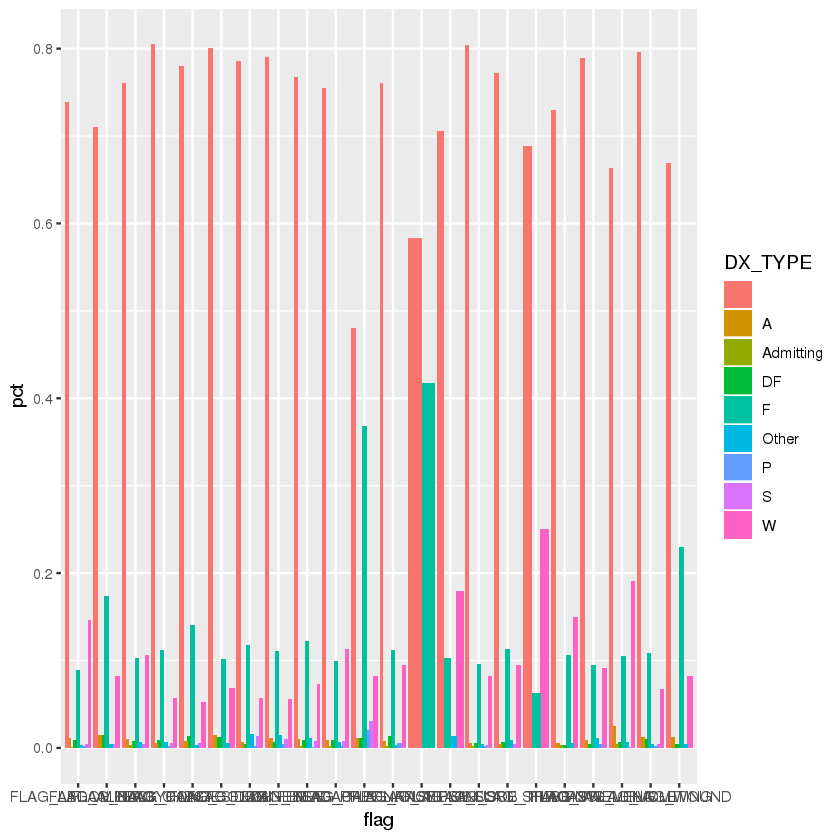

In [9]:
ggplot(PHESSgrpedFLAG, aes(x = flag, fill = DX_TYPE, y = pct)) + 
geom_bar(stat = "identity", position = "dodge")

**Thought and improvement**: what changes can be made to make the above graph more palatable and usable? Is using the more common flags more helpful? Or perhaps this might have a larger public health impact as these are more common events, i.e. those that impact a larger portion of the population under study?

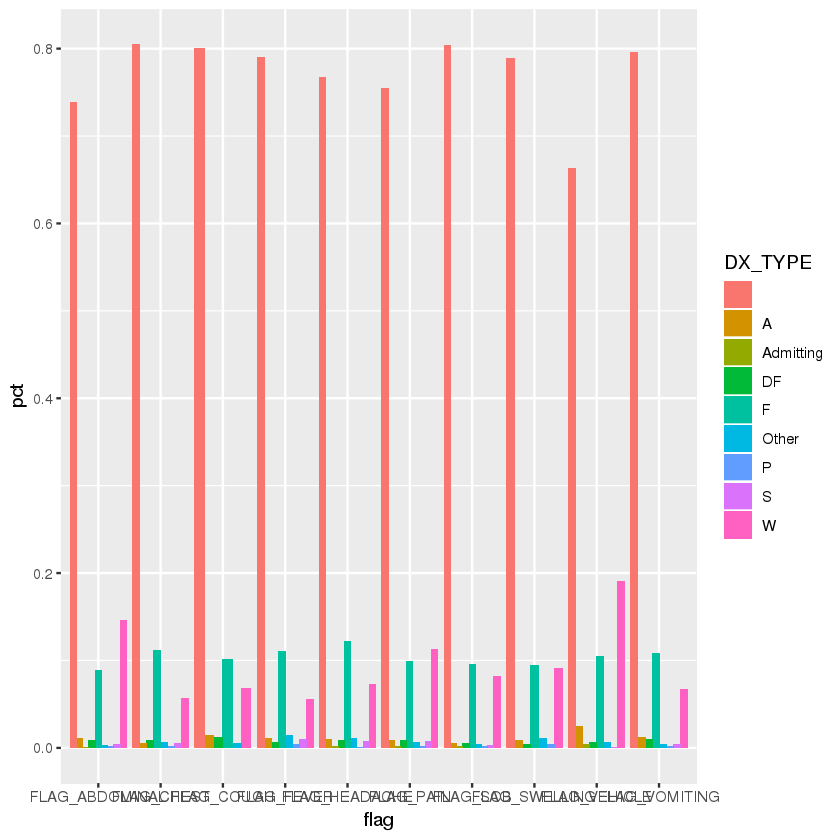

In [10]:
# Do the 10 most common flags
PHESSgrpedFLAGSm <- PHESSgrpedFLAG %>% group_by(flag) %>% mutate(total = sum(n)) %>% 
arrange(desc(total)) %>% ungroup() %>% filter(total %in% 
                                              sort(unique(total), decreasing = TRUE)[1:10])
PHESSgrpedFLAGSm %>% ggplot(aes(x = flag, fill = DX_TYPE, y = pct)) + 
geom_bar(stat = "identity", position = "dodge")

In **ggplot2**, we can also modify the labels in the x-axis using the <font color = "red">theme()</font> function:

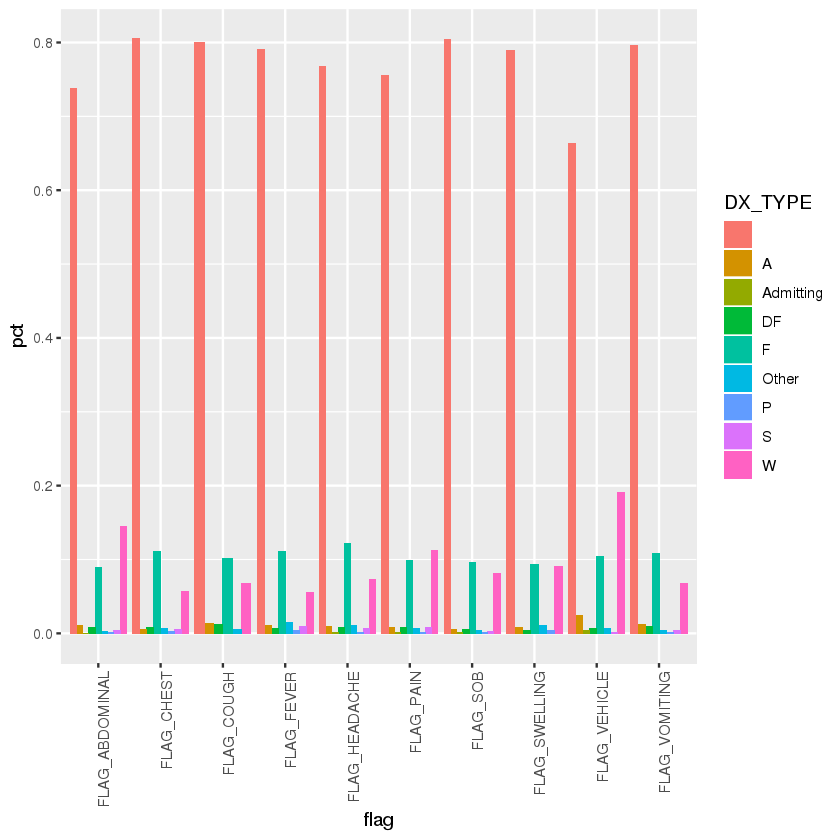

In [11]:
# Do the 10 most common flags
PHESSgrpedFLAGSm <- PHESSgrpedFLAG %>% group_by(flag) %>% mutate(total = sum(n)) %>% 
arrange(desc(total)) %>% ungroup() %>% filter(total %in% 
                                              sort(unique(total), decreasing = TRUE)[1:10])
PHESSgrpedFLAGSm %>% ggplot(aes(x = flag, fill = DX_TYPE, y = pct)) + 
geom_bar(stat = "identity", position = "dodge") + theme(axis.text.x = element_text(angle = 90, hjust = 1))

Are you happy with the above or are there additional changes one might make? If so, make those changes to increase the aesthetic appeal of the plots created so far

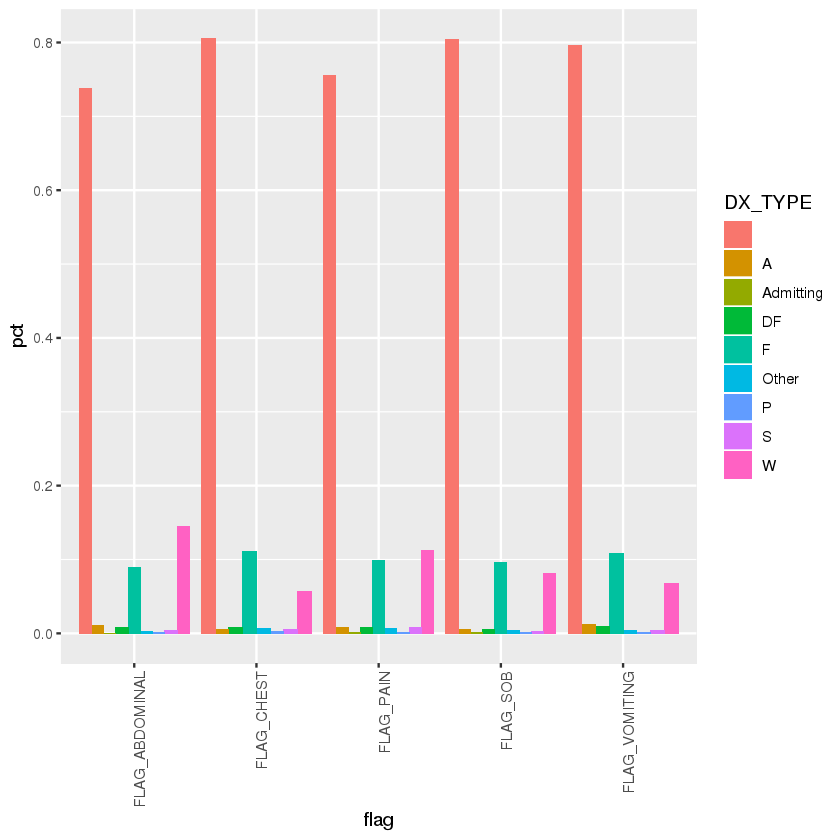

In [12]:
## top 5
## Do the 10 most common flags
PHESSgrpedFLAGSm <- PHESSgrpedFLAG %>% group_by(flag) %>% mutate(total = sum(n)) %>% 
arrange(desc(total)) %>% ungroup() %>% 
filter(total %in% sort(unique(total), decreasing = TRUE)[1:5])
PHESSgrpedFLAGSm %>% ggplot(aes(x = flag, fill = DX_TYPE, y = pct)) + 
geom_bar(stat = "identity", position = "dodge") + theme(axis.text.x = element_text(angle = 90, hjust = 1))

## Dimension Reduction Techniques

With so many flags, it can be a little difficult to know what is going on in our data. Researchers might be interested in creating a smaller number of factors or indicators that represent the data and provide a more direct or parsimonious route to modeling or visualization. A common route taken in these situations is termed **dimension reduction**, and this can be pursued either informally, based on correlations between the set of variable, more formally using hierarchical clustering methods, or by finding directions with the most variability (factor analysis). We'll consider the correlations first using the **corrplot** package. 

Create a correlation matrix using the <font color = "red">cor()</font> function for all flag data in the <font color = "blue">PHESS</font> data (use the Pearson Phi coefficient for binary data):

In [12]:
flagNames <- names(PHESS)[str_detect(names(PHESS), "FLAG_")]
corrMat <- cor(PHESS[,flagNames], method = "pearson")
## round to two decimal places
round(corrMat, 2)

Warning message in cor(PHESS[, flagNames], method = "pearson"):
"the standard deviation is zero"

,FLAG_ABDOMINAL,FLAG_RASH,FLAG_SEPSIS,FLAG_CHEST,FLAG_COUGH,FLAG_SOB,FLAG_DIZZINESS,FLAG_FEVER,FLAG_VOMITING,FLAG_WOUND,...,FLAG_VEHICLE,FLAG_HEADACHE,FLAG_PAIN,FLAG_PREGNANCY,FLAG_STABBING,FLAG_STI,FLAG_SORE_THROAT,FLAG_SWELLING,FLAG_SINUS,FLAG_FALL
FLAG_ABDOMINAL,1.00,-0.02,0.00,-0.02,-0.02,-0.02,0.00,0.01,0.05,0.00,...,-0.02,-0.01,0.14,0.01,0.00,0.00,-0.01,-0.01,0.00,NA
FLAG_RASH,-0.02,1.00,0.00,-0.01,0.00,-0.01,0.00,0.01,-0.01,0.00,...,-0.01,-0.01,-0.03,0.00,0.00,-0.01,0.01,0.01,0.00,NA
FLAG_SEPSIS,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,-0.01,0.00,0.00,0.02,0.00,0.00,0.00,NA
FLAG_CHEST,-0.02,-0.01,0.00,1.00,0.00,0.03,0.01,-0.01,-0.01,-0.01,...,-0.01,-0.01,0.43,0.00,0.00,-0.01,-0.01,-0.01,0.00,NA
FLAG_COUGH,-0.02,0.00,0.00,0.00,1.00,0.06,0.00,0.25,0.03,-0.01,...,-0.01,0.01,0.00,0.00,0.00,0.00,0.09,0.00,0.01,NA
FLAG_SOB,-0.02,-0.01,0.00,0.03,0.06,1.00,0.01,0.00,-0.01,-0.01,...,-0.01,-0.01,-0.01,0.00,0.00,-0.01,0.00,0.00,0.00,NA
FLAG_DIZZINESS,0.00,0.00,0.00,0.01,0.00,0.01,1.00,0.01,0.03,0.00,...,0.00,0.03,0.00,0.00,0.00,0.00,0.00,-0.01,0.00,NA
FLAG_FEVER,0.01,0.01,0.00,-0.01,0.25,0.00,0.01,1.00,0.09,0.00,...,-0.01,0.02,0.01,0.00,0.00,0.00,0.12,0.00,0.01,NA
FLAG_VOMITING,0.05,-0.01,0.00,-0.01,0.03,-0.01,0.03,0.09,1.00,-0.01,...,-0.01,0.03,0.03,0.01,0.00,0.00,0.01,-0.01,0.00,NA
FLAG_WOUND,0.00,0.00,0.00,-0.01,-0.01,-0.01,0.00,0.00,-0.01,1.00,...,-0.01,-0.01,-0.02,0.00,0.00,0.00,0.00,0.00,0.00,NA


Do you notice anything strange about any of the flags in the correlation matrix you created with <font color = "red">cor()</font>?


In [16]:
mean(PHESS$FLAG_FALL) ## no variability in FALL - there are no falls!

[1] 0

In [17]:
sd(PHESS$FLAG_FALL)

[1] 0

Remove any flag variables that aren't necessary to include, and use the <font color = "red">ggcorrplot()</font> function to create an aesthetically pleasing representation of the correlations between FLAG variables in the <font color = "blue">PHESS</font> data:

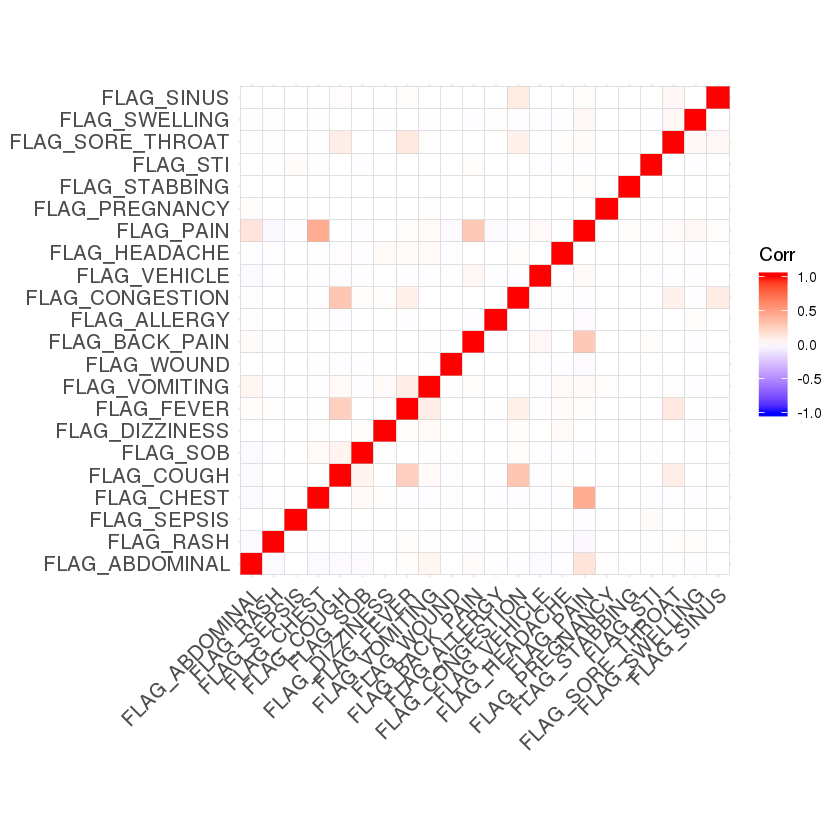

In [13]:
## remove FLAG_FALL:
## would like to use ggcorrplot() library(ggcorrplot)
flagNames <- names(PHESS)[str_detect(names(PHESS), "FLAG_")]
flagNames <- flagNames[!flagNames %in% "FLAG_FALL"]
corrMat <- cor(PHESS[,flagNames], method = 'pearson')
ggcorrplot(corrMat)

How about denoting the correlations in the plot? Modify your correlation plot (using function <font color = "red">ggcorrplot()</font> to do this:

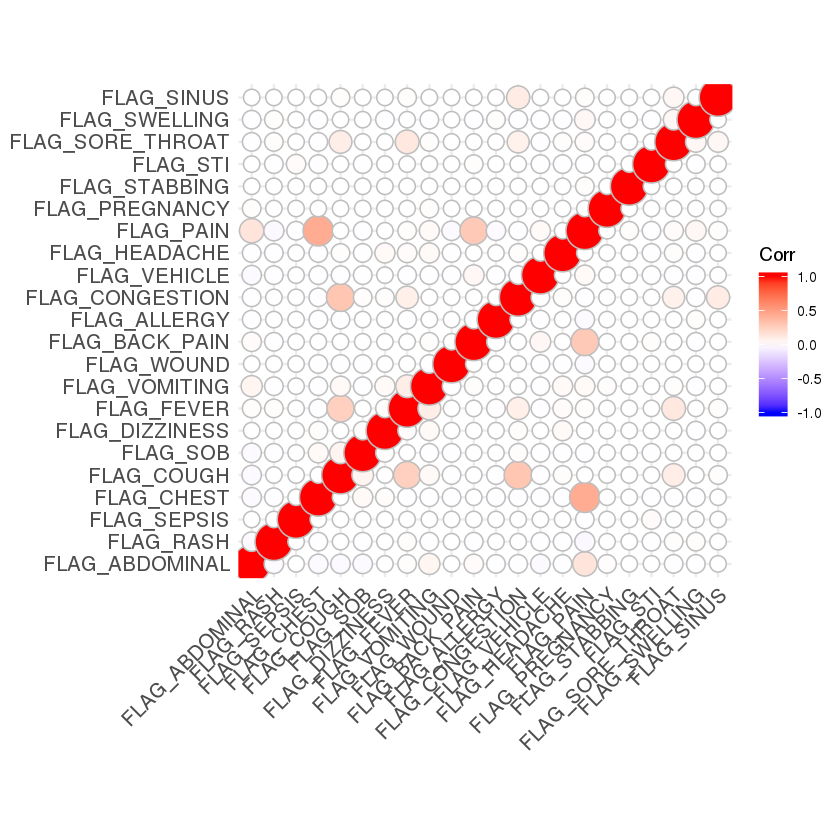

In [14]:
ggcorrplot(corrMat, method = "circle")

There are several reasonable conclusions from the above plot - but we don't have the correlation coefficient values represented. However, we can see that there seems to be positive correlations between FLAG_PAIN and FLAG_CHEST, FLAG_COUGH and FLAG_CONGESTION, and a couple other potential relationships that seem sensible. There is nothing surprising, but let's create another correlation plot-

Create a corrplot that only uses colors, no sizes or numbers, for the correlation values:

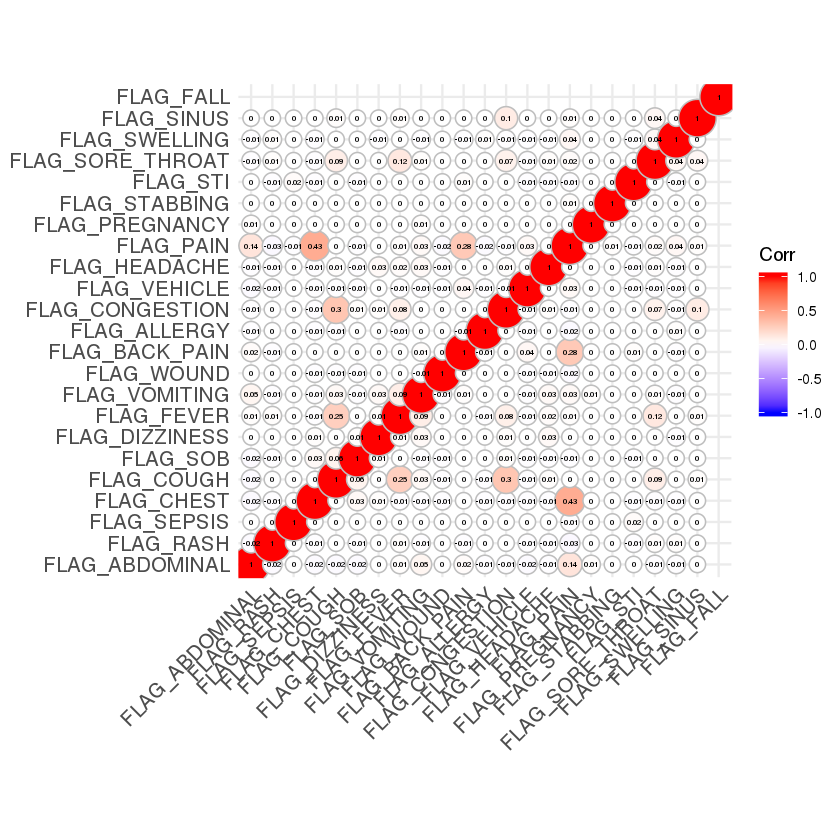

In [18]:
## lab = TRUE adds the corr values, lab_size changes the size
ggcorrplot(corrMat, method = "circle", lab = TRUE, lab_size = 1.5)

Now, apply dimension reduction (PCA) to determine whether there are "groups" of flags that might be combined. The <font color = "red">prcomp()</font> function will conduct PCA for you.

In [19]:
prComps <- prcomp(PHESS[,flagNames])
summary(prComps)

Importance of components:
                          PC1    PC2     PC3     PC4     PC5     PC6     PC7
Standard deviation     0.3185 0.1941 0.13701 0.13129 0.12710 0.11811 0.11251
Proportion of Variance 0.3493 0.1296 0.06462 0.05934 0.05561 0.04802 0.04358
Cumulative Proportion  0.3493 0.4789 0.54354 0.60287 0.65848 0.70651 0.75009
                           PC8     PC9    PC10    PC11    PC12    PC13    PC14
Standard deviation     0.10786 0.10526 0.09268 0.08949 0.08849 0.07559 0.07228
Proportion of Variance 0.04005 0.03814 0.02957 0.02757 0.02695 0.01967 0.01799
Cumulative Proportion  0.79014 0.82828 0.85785 0.88542 0.91238 0.93205 0.95003
                          PC15    PC16    PC17    PC18    PC19    PC20    PC21
Standard deviation     0.06062 0.05770 0.05301 0.04932 0.03129 0.02772 0.01897
Proportion of Variance 0.01265 0.01146 0.00967 0.00837 0.00337 0.00265 0.00124
Cumulative Proportion  0.96268 0.97415 0.98382 0.99220 0.99556 0.99821 0.99945
                          PC22 PC2

Visualize the first to components from the PCA using the <font color = "red">biplot()</font> function:

Warning message in arrows(0, 0, y[, 1L] * 0.8, y[, 2L] * 0.8, col = col[2L], length = arrow.len):
"zero-length arrow is of indeterminate angle and so skipped"Warning message in arrows(0, 0, y[, 1L] * 0.8, y[, 2L] * 0.8, col = col[2L], length = arrow.len):
"zero-length arrow is of indeterminate angle and so skipped"Warning message in arrows(0, 0, y[, 1L] * 0.8, y[, 2L] * 0.8, col = col[2L], length = arrow.len):
"zero-length arrow is of indeterminate angle and so skipped"Warning message in arrows(0, 0, y[, 1L] * 0.8, y[, 2L] * 0.8, col = col[2L], length = arrow.len):
"zero-length arrow is of indeterminate angle and so skipped"

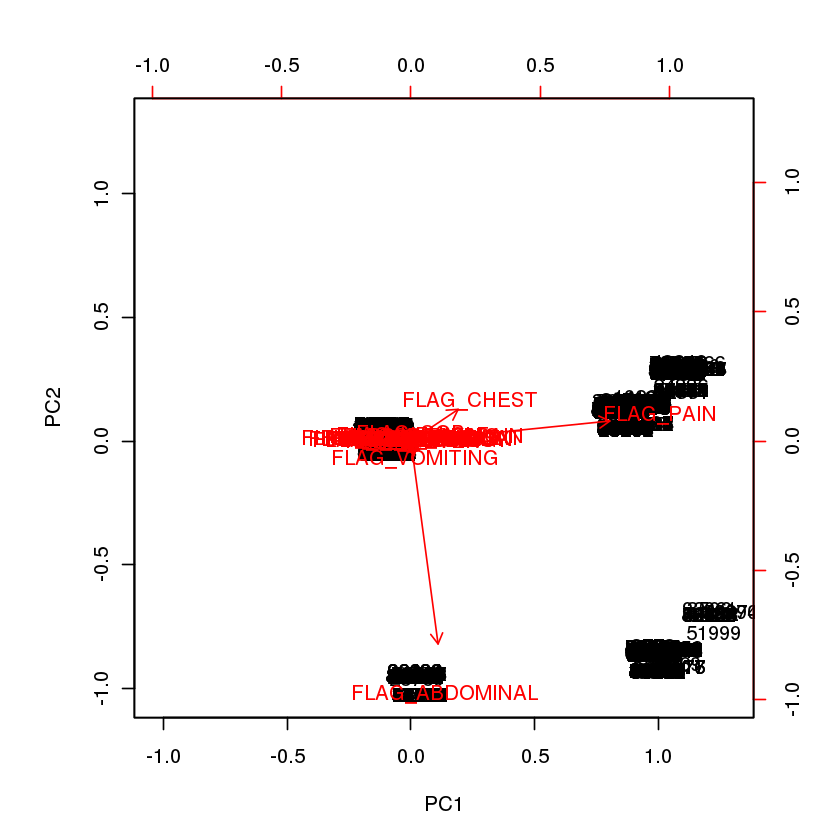

In [20]:
biplot(prComps, scale = 0)

Extract the portion of the overall variability in flags explained by the subsequent principal compponents (the **sdev** element from your PCA object will be helpful, as will the <font color = "red">sum()</font> function):

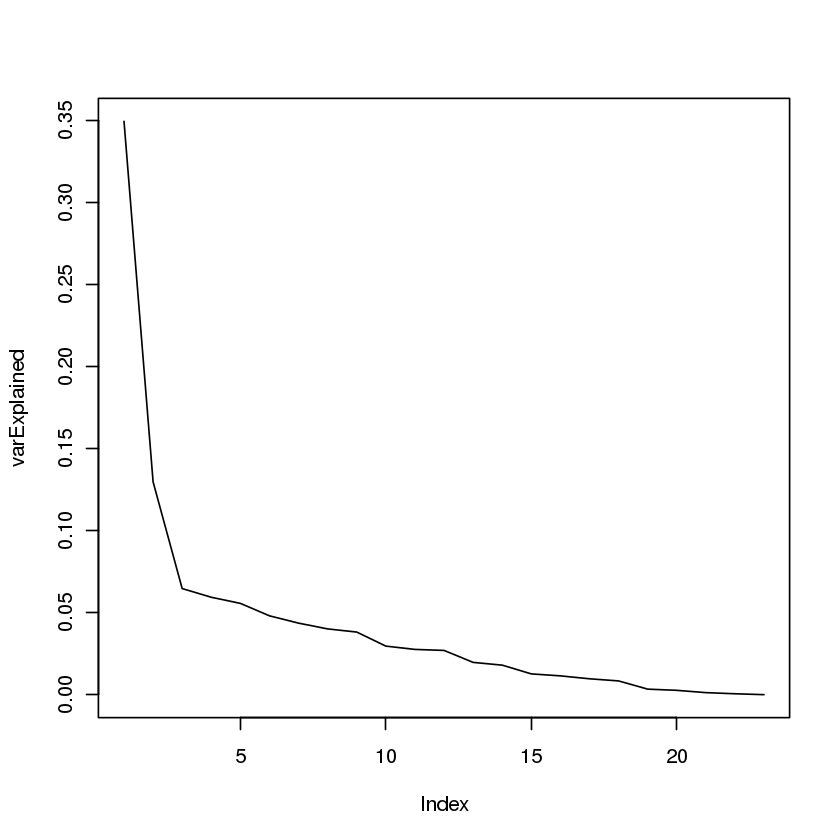

In [21]:
varExplained <- prComps$sdev ^ 2 / sum(prComps$sdev ^ 2)
plot(varExplained, type = 'l')

As can be seen above, the first principal component makes up nearly 35% of the entire variability in the FLAG data. The second makes up around 13%, the third about 6.5%, and so on.

How about the cumulative variability explained?

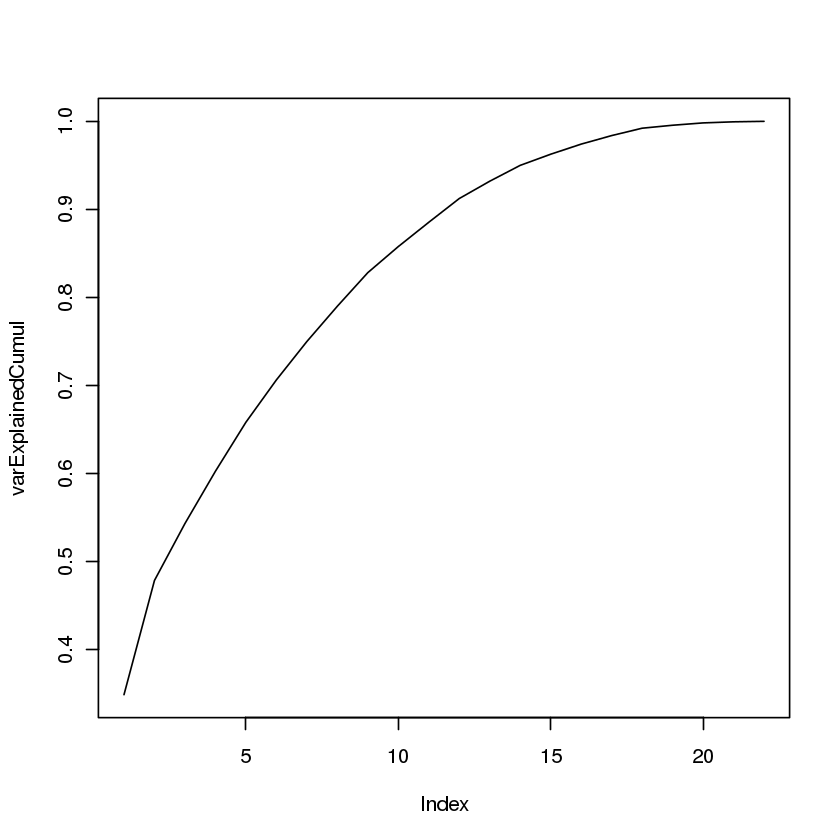

In [56]:
varExplainedCumul <- cumsum(prComps$sdev ^ 2) / sum(prComps$sdev ^ 2)
plot(varExplainedCumul, type = 'l')

The biplot is fairly difficult to read - there are many flags, but it seems that the abdominal flag has the largest weight or factor loading for principal component 2, and the pain flag has the largest weight or factor loading for principal component 1.

Investigate the loadings further to gain a better understanding of the first two principal components (loadings are held in the **rotation** element of your PCA object created with <font color = "red">prcomps()</font>:

In [59]:
prComps$rotation

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22
FLAG_ABDOMINAL,0.1310665788,-0.9800408886,-0.08907929367,-0.0800471151,0.0673953029,-0.03303524506,-0.0087171818,0.0055729622,-0.0324258413,0.01027490200,...,0.0070695404,-0.0012721333,0.0014033496,-0.00050746468,-0.0021521023,0.0009392819,-0.0008608537,-0.00030552977,0.00029495685,0.00031184047
FLAG_RASH,-0.0082428792,0.0057956968,0.00020811107,0.0109099025,0.0038752838,-0.02051187942,0.0215048471,0.0325568856,0.0120457065,-0.13916073755,...,-0.0128914960,-0.0061225576,0.0073389627,-0.00296112577,0.0025562776,0.0039965344,0.0010351048,-0.00086951407,0.00040134652,0.00014489840
FLAG_SEPSIS,-0.0004043146,0.0002547561,-0.00040441691,-0.0001103740,-0.0000795577,0.00037792440,0.0002500819,-0.0002215376,0.0005307965,-0.00007408726,...,-0.0001648888,0.0003144988,0.0055910541,-0.00012245764,0.0003747586,-0.0004476279,-0.0005038443,0.00062974288,0.99998319179,0.00025108045
FLAG_CHEST,0.2280744117,0.1531908845,-0.16035281027,-0.5274678834,0.7454181342,-0.09908577616,0.0022109556,0.0306828859,-0.0991103190,0.01989044959,...,0.0180597027,0.0041137021,0.0025374309,-0.00170253198,0.0008587303,0.0006847380,0.0012422554,-0.00098555915,0.00007363839,0.00072531452
FLAG_COUGH,-0.0019722535,0.0127836208,0.14291744945,-0.1305135403,-0.1400042878,-0.59939132355,0.0711182457,-0.0435111440,-0.0261549152,0.69703047040,...,-0.0988807773,0.0062738946,0.0109944155,0.25787270553,-0.0007637232,0.0015931340,0.0006287803,-0.00944935669,0.00029322825,0.00009435505
FLAG_SOB,-0.0016732813,0.0261448202,-0.06586148437,-0.7985847900,-0.5556030788,0.20120498323,-0.0514550879,-0.0074731911,-0.0165457002,-0.06850185586,...,0.0098080338,0.0104439968,0.0031406410,-0.00777176125,-0.0013110670,0.0029956606,0.0003075831,-0.00005537393,-0.00024225975,0.00014293125
FLAG_DIZZINESS,0.0011067207,0.0003592922,0.02398066682,-0.0144966848,0.0016360134,0.00008541963,-0.0294099253,-0.0017970607,0.0007720853,-0.00512029042,...,-0.0411636181,-0.9981518597,-0.0076826368,0.01298494461,-0.0051339303,0.0039233212,-0.0009818177,-0.00111864088,0.00036729690,0.00014653439
FLAG_FEVER,0.0043848115,-0.0056650113,0.25001387540,-0.0732404310,-0.0979061950,-0.66852472986,0.0964772681,-0.0227376392,-0.0383935268,-0.65265313800,...,-0.1257548471,0.0127884319,-0.0033008753,-0.03563382620,-0.0033477750,0.0005493790,0.0012233898,0.00131277010,0.00022374217,0.00013478380
FLAG_VOMITING,0.0151736758,-0.0702456129,0.92960156320,-0.1225724944,0.1548664855,0.28694308716,0.0626283582,0.0164865792,-0.0276485880,0.05955107016,...,0.0115198503,0.0215821706,0.0027236757,-0.00223789168,-0.0005147999,0.0025175057,-0.0029547322,-0.00089148075,0.00028382837,0.00017053315
FLAG_WOUND,-0.0024353486,0.0004680135,-0.00287350237,0.0027266055,0.0018814038,0.00118201820,0.0024615443,-0.0007626300,0.0039572951,-0.00091846491,...,-0.0025407697,0.0038858838,-0.0079861317,0.00331087212,0.0211733824,0.9996917587,0.0016067356,-0.00083845190,0.00047710932,0.00016263397


As can be seen above, the first column provides the loadings for each of the original values which map to PC1 - the first principal component. The first principal component, and thus the most variability in the <font color = "blue">PHESS</font> data, is FLAG_PAIN. The second principal component is mostly made up of FLAG_ABDOMINAL. The columns of the rotation matrix show how much each variable (before applying PCA) contributes to the respective components. These two flags most likely account for the most variability (i.e. largest percentages of zeroes and 1) in the data. Can you demonstrate this by summarizing the data?

In [13]:
means <- purrr::map_dbl(flagNames, function(t) {mean(PHESS[,t])})
names(means) <- flagNames
means
## alternatively with dplyr
meansTbl <- PHESS %>% summarise_at(.vars = vars(contains("FLAG")), mean) %>% 
rename_at(.vars = vars(contains("FLAG")), function(t) {paste0("mean", t)})
meansTbl

FLAG_ABDOMINAL        FLAG_RASH      FLAG_SEPSIS       FLAG_CHEST 
         0.03987          0.00810          0.00036          0.02148 
      FLAG_COUGH         FLAG_SOB   FLAG_DIZZINESS       FLAG_FEVER 
         0.01078          0.01702          0.00527          0.01186 
   FLAG_VOMITING       FLAG_WOUND   FLAG_BACK_PAIN     FLAG_ALLERGY 
         0.01867          0.00244          0.00914          0.00282 
 FLAG_CONGESTION     FLAG_VEHICLE    FLAG_HEADACHE        FLAG_PAIN 
         0.00386          0.01134          0.01288          0.10621 
  FLAG_PREGNANCY    FLAG_STABBING         FLAG_STI FLAG_SORE_THROAT 
         0.00098          0.00016          0.00369          0.00596 
   FLAG_SWELLING       FLAG_SINUS        FLAG_FALL 
         0.01172          0.00078          0.00000

meanFLAG_ABDOMINAL,meanFLAG_RASH,meanFLAG_SEPSIS,meanFLAG_CHEST,meanFLAG_COUGH,meanFLAG_SOB,meanFLAG_DIZZINESS,meanFLAG_FEVER,meanFLAG_VOMITING,meanFLAG_WOUND,...,meanFLAG_VEHICLE,meanFLAG_HEADACHE,meanFLAG_PAIN,meanFLAG_PREGNANCY,meanFLAG_STABBING,meanFLAG_STI,meanFLAG_SORE_THROAT,meanFLAG_SWELLING,meanFLAG_SINUS,meanFLAG_FALL
0.03987,0.0081,0.00036,0.02148,0.01078,0.01702,0.00527,0.01186,0.01867,0.00244,...,0.01134,0.01288,0.10621,0.00098,0.00016,0.00369,0.00596,0.01172,0.00078,0


Notice that FLAG_PAIN has the highest mean (10.6% of the data had a value of 1 for FLAG_PAIN), followed by FLAG_ABDOMINAL. Thus, these ARE the two FLAG variables constituting the most variability in the dataset.

Comment on the success or lack thereof of the PCA analysis:

In this case, PCA did not necessarily identify meaningful components, but instead (when looking only at the first two PCs) found the two directions in which the most variability was found to be roughly equal to the two FLAG variables that had the most variability (PAIN and ABDOMINAL, respectively). 
